# 1) Se cargan las librerias necesarias

In [211]:
# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Selección, validación de modelos y técnicas de balanceo de clases
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Librerías para Deep Learning con PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# 2) Carga y visualización de la base de datos

In [212]:
medical_appointments = pd.read_csv('Attendance of Medical Appointments in Brazil (may2016).csv')

In [213]:
# Numero de filas y columnas
medical_appointments.shape

(110527, 14)

In [214]:
# Encabezados
medical_appointments.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [215]:
# Numero de valores unicos por columna
column_counts = medical_appointments.nunique()
print(column_counts)

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


In [216]:
# Tipo de datos
data_types = medical_appointments.dtypes
print(data_types)

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


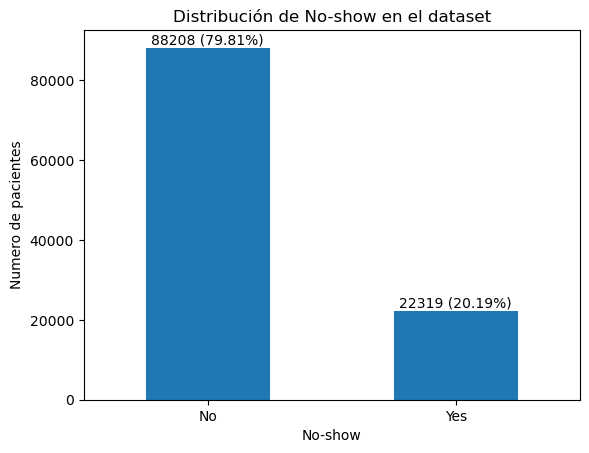

In [217]:
# Distribución del dataset
class_counts = medical_appointments['No-show'].value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(medical_appointments) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

In [218]:
# Evaluar presencia de Missing values
missing_values = medical_appointments.isnull().sum()
print(missing_values)

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


# 3) Feature Engeniering

In [219]:
# Se crea una copia del dataset original
medical_appointments_transformed = medical_appointments.copy()

# Transformar las fechas a formato datetime
medical_appointments_transformed['ScheduledDay'] = pd.to_datetime(medical_appointments_transformed['ScheduledDay'])
medical_appointments_transformed['AppointmentDay'] = pd.to_datetime(medical_appointments_transformed['AppointmentDay'])

# Se ordena el dataframe por el id del paciente y la fecha de la cita
medical_appointments_transformed.sort_values(by=['PatientId', 'ScheduledDay'], inplace=True)

# Se calcula el tiempo en segundos entre la fecha de la cita y la fecha de programación
medical_appointments_transformed['Time_Before_Appointment'] = (medical_appointments_transformed['AppointmentDay'] - medical_appointments_transformed['ScheduledDay']).dt.total_seconds()

# Se agrega el día de la semana de la cita
medical_appointments_transformed['Appointment_DayOfWeek'] = medical_appointments_transformed['AppointmentDay'].dt.day_name()

# Se calcula el tiempo en días desde la última cita de cada paciente
medical_appointments_transformed['Days Since Last Appointment'] = medical_appointments_transformed.groupby('PatientId')['ScheduledDay'].diff().dt.days

# Se asgina 0 a los pacientes que no tienen citas previas
medical_appointments_transformed['Days Since Last Appointment'].fillna(0, inplace=True)

# Se convierte de time a int
medical_appointments_transformed['ScheduledDay'] = medical_appointments_transformed['ScheduledDay'].dt.strftime('%Y%m%d').astype(int)
medical_appointments_transformed['AppointmentDay'] = medical_appointments_transformed['AppointmentDay'].dt.strftime('%Y%m%d').astype(int)

# Instanciar un nuevo LabelEncoder para cada columna categórica
gender_encoder = LabelEncoder()
neighbourhood_encoder = LabelEncoder()
no_show_encoder = LabelEncoder()
Appointment_DayOfWeek_encoder = LabelEncoder()

# Convertir las columnas categóricas a numéricas usando fit_transform
medical_appointments_transformed['Gender'] = gender_encoder.fit_transform(medical_appointments_transformed['Gender'])
medical_appointments_transformed['Neighbourhood'] = neighbourhood_encoder.fit_transform(medical_appointments_transformed['Neighbourhood'])
medical_appointments_transformed['No-show'] = no_show_encoder.fit_transform(medical_appointments_transformed['No-show'])
medical_appointments_transformed['Appointment_DayOfWeek'] = Appointment_DayOfWeek_encoder.fit_transform(medical_appointments_transformed['Appointment_DayOfWeek'])

# Visualizar los cambios
medical_appointments_transformed.head(10)



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment
100517,3.921784e+04,5751990,0,20160531,20160603,44,56,0,0,0,0,0,0,0,219799.0,0,0.0
105430,4.374176e+04,5760144,1,20160601,20160601,39,43,0,0,1,0,0,0,0,-51778.0,5,0.0
3950,9.377953e+04,5712759,0,20160518,20160518,33,10,0,0,0,0,0,0,0,-33149.0,5,0.0
73303,1.417242e+05,5637648,1,20160429,20160502,12,23,0,0,0,0,0,0,0,233184.0,1,0.0
73228,5.376153e+05,5637728,0,20160429,20160506,14,23,0,0,0,0,0,1,0,578403.0,0,0.0
54611,5.628261e+06,5680449,1,20160510,20160513,13,52,0,0,0,0,0,0,1,216102.0,0,0.0
40692,1.183186e+07,5718578,1,20160519,20160519,16,69,0,0,0,0,0,0,0,-34927.0,3,0.0
58616,2.263866e+07,5580835,0,20160414,20160503,22,35,0,0,0,0,0,1,0,1614990.0,4,0.0
88585,2.263866e+07,5715081,0,20160518,20160608,23,35,0,0,0,0,0,1,0,1765368.0,5,34.0
49826,5.216894e+07,5607220,0,20160420,20160517,28,39,0,0,0,0,0,0,0,2291865.0,4,0.0


# 3.1) Se divide el dataset en conjunto de entrenamiento y prueba
Para continuar el procesamiento

In [220]:
# Dividir el dataframe en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(medical_appointments_transformed, test_size=0.2, stratify=medical_appointments_transformed['No-show'], random_state=42)

# 3.2) Feature Engeniering parte 2: 
Se generan variables del dataset de entrenamiento: porcentaje de inasistencias de pacientes a sus citas, para no contaminar los datos de test, que son datos futuros y no contamos con esa información

In [221]:
# Calcular la suma acumulativa de inasistencias ('No-show' == 1) por PatientId
train_df['Cumulative No-shows'] = train_df.groupby('PatientId')['No-show'].transform('cumsum')

# Calcular el número acumulativo de citas por PatientId
train_df['Cumulative Appointments'] = train_df.groupby('PatientId').cumcount() + 1

# Calcular la probabilidad acumulativa de inasistencia por cita
train_df['Cumulative No-show Probability'] = train_df['Cumulative No-shows'] / train_df['Cumulative Appointments']

# Asignar un valor de 0 a la primera cita de cada paciente utilizando transform para mantener el índice
train_df['Cumulative No-show Probability'] = train_df.groupby('PatientId')['Cumulative No-show Probability'].transform(lambda x: x.shift().fillna(0))

# Se observan los cambios
train_df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment,Cumulative No-shows,Cumulative Appointments,Cumulative No-show Probability
23910,5.455992e+13,5689407,0,20160512,20160512,7,3,1,0,0,0,0,0,0,-30331.0,3,0.0,0,1,0.0
76693,6.326830e+13,5670801,1,20160506,20160506,69,43,0,0,0,0,0,0,0,-52930.0,0,0.0,0,1,0.0
33049,6.752995e+14,5676178,1,20160509,20160509,8,69,0,0,0,0,0,0,0,-54528.0,1,0.0,0,1,0.0
104399,7.751915e+12,5767585,1,20160602,20160608,77,43,0,0,0,0,0,1,0,450666.0,5,0.0,0,1,0.0
97582,2.411723e+14,5698414,1,20160516,20160606,21,69,0,0,0,0,0,1,0,1787195.0,1,0.0,0,1,0.0
26730,1.914162e+11,5680594,0,20160510,20160511,67,8,0,0,0,0,0,0,0,42236.0,5,0.0,0,1,0.0
57079,7.225878e+13,5595452,1,20160418,20160502,6,10,0,0,0,0,0,1,0,1163680.0,1,0.0,0,1,0.0
80237,1.331540e+13,5712932,0,20160518,20160531,13,10,0,0,0,0,0,1,0,1089025.0,4,0.0,0,1,0.0
19180,1.965328e+13,5703004,1,20160516,20160517,2,5,0,0,0,0,0,0,0,38173.0,4,0.0,0,1,0.0
104678,7.766713e+11,5773168,1,20160606,20160608,57,40,0,0,0,1,0,0,0,148398.0,5,0.0,0,1,0.0


In [222]:
# Se divide en conjuntos de entrenamiento y prueba
X_train = train_df.drop(columns=['No-show'])
y_train = train_df['No-show']
X_test = test_df.drop(columns=['No-show'])
y_test = test_df['No-show']

# 3.3) Se cruza la informacion con el dataset de test

In [223]:
# Unir el DataFrame de test con los porcentajes de 'No-show' basados en 'PatientId', y las columnas 'Cumulative No-show Probability', 'Cumulative Appointments' y Cumulative No-shows
X_test = X_test.merge(train_df[['PatientId', 'Cumulative No-show Probability', 'Cumulative Appointments', 'Cumulative No-shows']].drop_duplicates(), on='PatientId', how='left')

# En el caso de los pacientes que no tienen citas previas, se asigna la probabilidad de inasistencia promedio
X_test['Cumulative No-show Probability'].fillna(y_train.mean(), inplace=True)

# Se observan los cambios
X_test.head(10)



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment,Cumulative No-show Probability,Cumulative Appointments,Cumulative No-shows
0,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.000000,1.0,0.0
1,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.000000,2.0,1.0
2,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.500000,3.0,2.0
3,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.666667,4.0,3.0
4,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.750000,5.0,4.0
5,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.800000,6.0,4.0
6,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.666667,7.0,5.0
7,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.714286,8.0,6.0
8,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.750000,9.0,6.0
9,2.728422e+12,5636094,0,20160428,20160520,44,76,0,0,0,0,0,0,1848606.0,0,0.0,0.666667,10.0,7.0


# 3.4) Se elimina la información no relevante

In [224]:
# Se elimina la informacion que no es relevante
X_train = X_train.drop(['PatientId', 'AppointmentID'], axis=1)
X_test = X_test.drop(['PatientId', 'AppointmentID'], axis=1)

# Se verifican dimensiones de los conjuntos de datos
X_train.shape, X_test.shape
print(X_train.shape, X_test.shape)

(88421, 17) (53778, 17)


# 4) Se Estandariza la base de datos

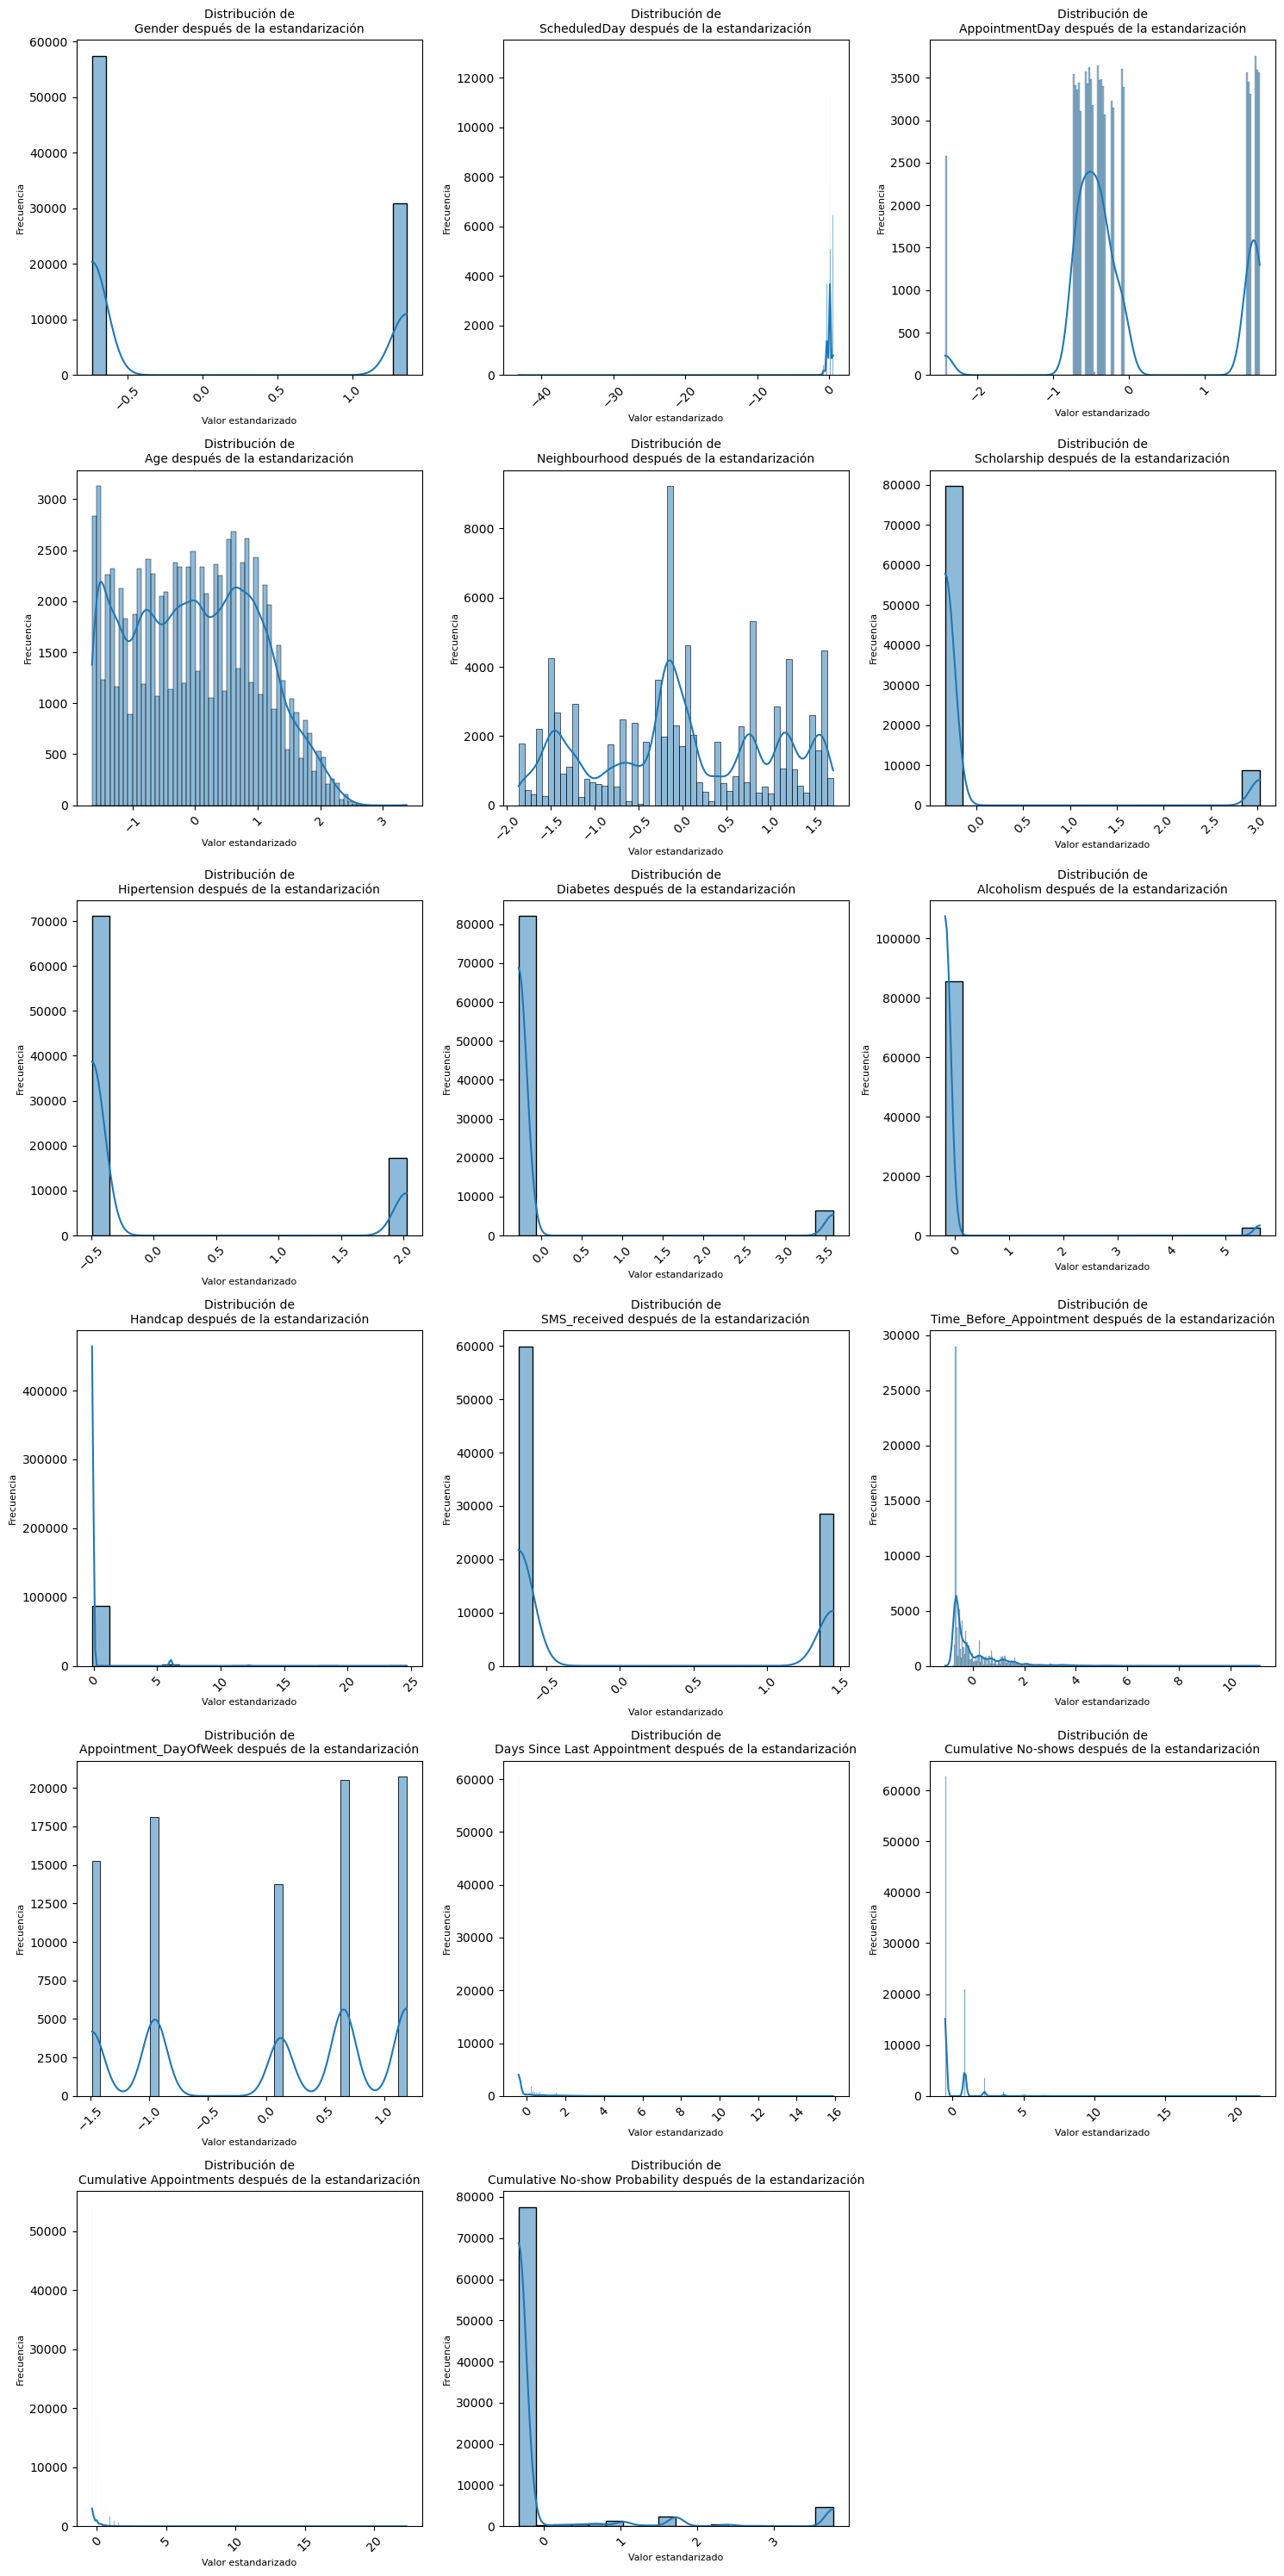

In [225]:
# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos balanceados y se transforman
X_balanced_scaled = scaler.fit_transform(X_train)

# Convertir el resultado a DataFrame para facilitar la manipulación y visualización
X_balanced_scaled_df = pd.DataFrame(X_balanced_scaled, columns=X_train.columns)

# Número de características en el DataFrame
num_features = X_balanced_scaled_df.shape[1]

# Número de columnas para los subgráficos
num_columns = 3

# Número de filas calculadas en función del número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)

# Crear una figura grande para acomodar todos los subgráficos
plt.figure(figsize=(15, 5 * num_rows))

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)
    sns.histplot(X_balanced_scaled_df.iloc[:, i], kde=True)
    
    # Usar un salto de línea para dividir el título en dos líneas
    plt.title(f'Distribución de\n{X_balanced_scaled_df.columns[i]} después de la estandarización', fontsize=10)
    
    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45) 

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


# 5) Se realiza balanceo de clases

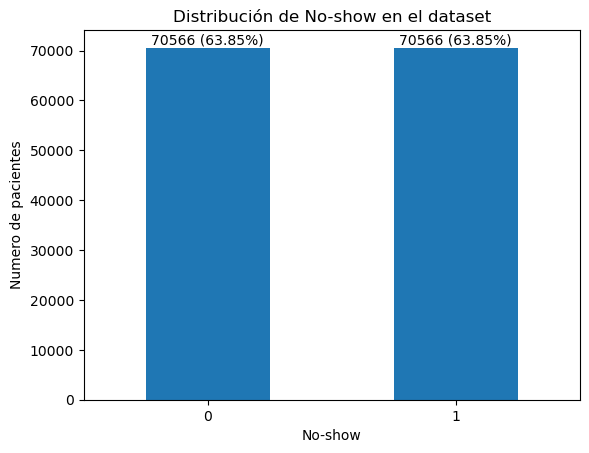

In [226]:
# Se crea una instancia de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Se aplica SMOTE a los datos
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('rus', rus)])

# Se aplica el pipeline a los datos
X_balanced, y_balanced = pipeline.fit_resample(X_train, y_train)

# Distribución del dataset posterior a la aplicación de SMOTE
class_counts = y_balanced.value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(medical_appointments) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

# 6) Entrenamiento de modelos de Machine Learning:

In [227]:
# Definir las etiquetas para la matriz de confusión
labels = ['Asiste', 'No-show']

6.1 Entrenamiento Regresión Logisitica

In [228]:
# Crear una instancia de LogisticRegression
clf_logistic = LogisticRegression()

# Diccionario de parametros a probar
param_grid = {
    'max_iter': [1000, 2000], # Numero de iteraciones
    'penalty': ['l2'], # Tipos de penalización
    'C': [0.01, 0.1, 1, 10, 100], # Valores de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # Algoritmos para la optimización
}

# Crear una instancia de GridSearchCV optimizada para la precisión
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)

# Ajustar GridSearchCV
grid_search.fit(X_balanced, y_balanced)

# Ver los mejores parámetros y el mejor modelo
print('Mejores parámetros encontrados:', grid_search.best_params_)
print('Mejor modelo:', grid_search.best_estimator_)

# Se prueba el modelo en el conjunto de prueba (sin balancear)
y_pred_test_logistic = grid_search.best_estimator_.predict(X_test)

# Se crea una matriz de confusión utilizando el conjunto de prueba real y las predicciones
confusion_mat_test_logistic = confusion_matrix(y_test, y_pred_test_logistic)
sns.heatmap(confusion_mat_test_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión Regresión Logística (Mejores Parámetros)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Se calculan las métricas de evaluación utilizando el conjunto de prueba real
accuracy_test_logistic = accuracy_score(y_test, y_pred_test_logistic)
precision_test_logistic = precision_score(y_test, y_pred_test_logistic, pos_label=1)
recall_test_logistic = recall_score(y_test, y_pred_test_logistic, pos_label=1)

print("Accuracy (Conjunto de Prueba):", accuracy_test_logistic)
print("Precision (Conjunto de Prueba):", precision_test_logistic)
print("Recall (Conjunto de Prueba):", recall_test_logistic)
plt.show()



Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/luisortiz/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/luisortiz/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/luisortiz/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/luisortiz/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/luisortiz/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearc

8.2 Entrenamiento de DecisionTreeClassifier (Datos balanceados)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mejor puntaje de accuracy: 0.7186681987364272


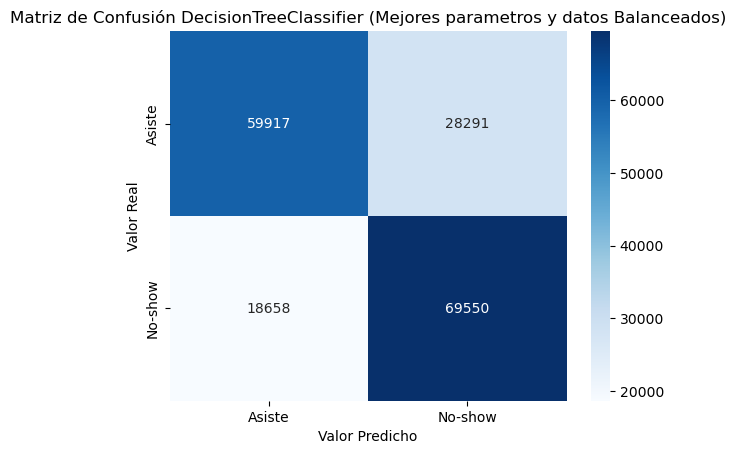

Accuracy (Datos Balanceados): 0.7338733448213314
Precision (Datos Balanceados): 0.7108471908504614
Recall (Datos Balanceados): 0.7884772356248866


In [ ]:
# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en cada nodo hoja
    'criterion': ['gini', 'entropy']  # Función para medir la calidad de una división
}

# Crear una instancia de GridSearchCV, optimizada para la precisión
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='precision', n_jobs=-1)

# Ajustar GridSearchCV a los datos
grid_search.fit(X_balanced, y_balanced)

# Imprimir los mejores parámetros y el mejor puntaje
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntaje de precisión:", grid_search.best_score_)

# Usar el mejor modelo para realizar predicciones
best_tree = grid_search.best_estimator_
y_pred_balanced = cross_val_predict(best_tree, X_balanced, y_balanced, cv=5)

# Crear y visualizar la matriz de confusión
confusion_mat_balanced = confusion_matrix(y_balanced, y_pred_balanced)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión DecisionTreeClassifier (Mejores parámetros y datos balanceados)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Calcular y mostrar las métricas de evaluación
accuracy_balanced = accuracy_score(y_balanced, y_pred_balanced)
precision_balanced = precision_score(y_balanced, y_pred_balanced, pos_label=1)
recall_balanced = recall_score(y_balanced, y_pred_balanced, pos_label=1)

print("Accuracy (Datos Balanceados):", accuracy_balanced)
print("Precision (Datos Balanceados):", precision_balanced)
print("Recall (Datos Balanceados):", recall_balanced)

#Accuracy (Datos Balanceados): 0.7338733448213314
#Precision (Datos Balanceados): 0.7108471908504614
#Recall (Datos Balanceados): 0.7884772356248866


8.3 Entrenamiento de red neuronal

In [ ]:
# 1. Definir la arquitectura de la red neuronal
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

#2. Preparar los datos para PyTorch
X_balanced_tensor = torch.tensor(X_balanced.astype(np.float32))
y_balanced_tensor = torch.tensor(y_balanced.astype(np.float32))
train_dataset = TensorDataset(X_balanced_tensor, y_balanced_tensor)

# 3. Implementar una función de entrenamiento y evaluación
def train_and_evaluate(model, train_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# 4. Realizar la búsqueda de hiperparámetros manualmente
hidden_sizes = [64, 128, 256]
learning_rates = [0.001, 0.01, 0.1]
best_accuracy = 0

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        model = NeuralNet(input_size=X_balanced.shape[1], hidden_size=hidden_size, num_classes=len(np.unique(y_balanced)))
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
        train_and_evaluate(model, train_loader, criterion, optimizer)

        # Evaluar el modelo
        model.eval()
        with torch.no_grad():
            y_pred = model(X_balanced_tensor).max(1)[1].numpy()
        
        accuracy = accuracy_score(y_balanced, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'hidden_size': hidden_size, 'learning_rate': lr}
            best_model = model

print("Mejores parámetros:", best_params)
print("Mejor accuracy:", best_accuracy)

# 5. Crear y visualizar la matriz de confusión para el mejor modelo
best_model.eval()
with torch.no_grad():
    y_pred_best = best_model(X_balanced_tensor).max(1)[1].numpy()

confusion_mat = confusion_matrix(y_balanced, y_pred_best)
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión para el Mejor Modelo')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()
